# Classification des signes de la LSF

Dans ce notebook, nous allons réaliser un système de classification des signes du langage des signes français. 

## Installations et imports des modules

Nous lançons la cellule suivante pour installer mediapipe avec la dépendance opencv.

Importons les modules dont nous allons avoir besoin :

In [9]:
import mediapipe as mp # gère la détection
import cv2 # gère la computer vision
import pandas as pd # sert à manipuler le dataset
import numpy as np # manipulation d'array

from sklearn.preprocessing import LabelEncoder # encodage des données catégorielles
from sklearn.model_selection import train_test_split # division de la donnée en train/test sets
from sklearn.model_selection import StratifiedKFold  # division de la donnée en train/test sets
from sklearn.metrics import accuracy_score # calcul de la précision d'un modèle
from sklearn.ensemble import RandomForestClassifier # modèle de classification

import tensorflow as tf # création et entraînement de modèles de deep learning keras


Set up de deux composants mediapipe :

In [10]:
# Composant pour dessiner le résultat des détections sur le screen opencv
mp_drawing = mp.solutions.drawing_utils 

# Import de notre modèle holistique :
mp_holistic = mp.solutions.holistic

## Récupération du flux vidéo de la webcam

Voici un petit snippet minimaliste pour capturer le flux vidéo de la webcam avec opencv.

## Détection depuis le feed

Testons la détection des poses des mains via mediapipe sur le flux vidéo opencv.

## Création d'un dataset

Il y a vingt-et-un landmarks (points) créés par main détectée avec mediapipe. Récupérons nos images d'entraînement, nous allons utiliser mediapipe dessus afin de récupérer ces points pour les mains réalisant chaque signe.

**Import de la donnée :**

Nous importons maintenant notre dataset depuis un csv préalablement réalisé afin de remplir une variable de type dataframe. Ce dataset csv contient les noms des images, leurs chemins et surtout la cible associée : la lettre de l'alphabet des signes.

In [12]:
dataset = pd.read_csv(".\data.csv")
dataset

,Name,Path,Target
0,A_000,.\data\A\A_000.jpg,A
1,A_001,.\data\A\A_001.jpg,A
2,A_002,.\data\A\A_002.jpg,A
3,A_003,.\data\A\A_003.jpg,A
4,A_004,.\data\A\A_004.jpg,A
...,...,...,...
795,Z_027,.\data\Z\Z_027.jpg,Z
796,Z_028,.\data\Z\Z_028.jpg,Z
797,Z_029,.\data\Z\Z_029.jpg,Z
798,Z_030,.\data\Z\Z_030.jpg,Z


**Encodage des targets :** 

Nos cibles sont des strings de lettres allant de A à Z, il nous faut les encoder en int de 0 à 25.

In [13]:
label_enc = LabelEncoder()

label_enc.fit(dataset["Target"] )

#list(label_enc.classes_)

dataset["Target"] = label_enc.transform(dataset["Target"])

# Pour désencoder nos labels :
# list(label_enc.inverse_transform(y))

dataset["Target"]

0       0
1       0
2       0
3       0
4       0
       ..
795    25
796    25
797    25
798    25
799    25
Name: Target, Length: 800, dtype: int32

## Détection des mains.

Pour classer les signes, nos features d'entraînement ne seront pas des images comme dans un problème de classification sur images classique mais plutôt des valeurs de coordonnées pour les points (landmarks) de la main détectée sur chaque instance par mediapipe. C'est là-dessus que notre modèle apprendra puis prédira en conditions réelles.

Cependant, il nous faut d'abord détecter les mains sur nos images pour obtenir ces points.

In [14]:
images_path = dataset['Path'].values

# Les paramètres de holistic ont été fine-tunés pour limiter le nombre de ratages dans la détection de mains
with mp_holistic.Holistic(min_detection_confidence=0.6, min_tracking_confidence=0.9) as holistic:
    for i, row in dataset.iterrows(): # On énumère sur chaque ligne du dataset
        path = row.Path # On prent le path de l'image
        print(path)
        image = cv2.imread(path) # On charge l'image dans un array cv2
        img =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # On convertit l'image du BGR cv2 vers du RGB lisible par mediapipe
        
        results = holistic.process(img) # On réalise la détection de main sur l'image

        try:
            # On charge les landmarks de la main détectée dans une variable coordonnée
            coords = results.right_hand_landmarks.landmark
        
            for j, coord in enumerate(coords): # Pour chaque point on énumère les coordonnées
                # On ajoute au dataset les coordonnées xyz des points 0 à 20 :
                dataset.at[i,f'x{j}'] = coord.x 
                dataset.at[i,f'y{j}'] = coord.y
                dataset.at[i,f'z{j}'] = coord.z
            
        except Exception as e: # Certaines images sont sautées car la main n'est pas détectée par mediapipe
            print(e)

.\data\A\A_000.jpg
.\data\A\A_001.jpg
.\data\A\A_002.jpg
.\data\A\A_003.jpg
.\data\A\A_004.jpg
.\data\A\A_005.jpg
.\data\A\A_006.jpg
.\data\A\A_007.jpg
.\data\A\A_008.jpg
.\data\A\A_011.jpg
.\data\A\A_012.jpg
.\data\A\A_013.jpg
.\data\A\A_014.jpg
.\data\A\A_015.jpg
.\data\A\A_016.jpg
.\data\A\A_017.jpg
.\data\A\A_018.jpg
'NoneType' object has no attribute 'landmark'
.\data\A\A_019.jpg
.\data\A\A_020.jpg
.\data\A\A_021.jpg
.\data\A\A_022.jpg
.\data\A\A_023.jpg
.\data\A\A_024.jpg
.\data\A\A_025.jpg
.\data\A\A_026.jpg
.\data\A\A_027.jpg
'NoneType' object has no attribute 'landmark'
.\data\A\A_028.jpg
.\data\A\A_029.jpg
'NoneType' object has no attribute 'landmark'
.\data\A\A_030.jpg
.\data\A\A_031.jpg
.\data\A\A_032.jpg
.\data\B\B_000.jpg
.\data\B\B_001.jpg
'NoneType' object has no attribute 'landmark'
.\data\B\B_002.jpg
.\data\B\B_003.jpg
'NoneType' object has no attribute 'landmark'
.\data\B\B_004.jpg
.\data\B\B_005.jpg
.\data\B\B_006.jpg
'NoneType' object has no attribute 'landmark'
.\

.\data\J\J_008.jpg
'NoneType' object has no attribute 'landmark'
.\data\J\J_009.jpg
.\data\J\J_010.jpg
.\data\J\J_011.jpg
.\data\J\J_012.jpg
.\data\J\J_013.jpg
.\data\J\J_014.jpg
.\data\J\J_015.jpg
.\data\J\J_016.jpg
.\data\J\J_017.jpg
.\data\J\J_018.jpg
'NoneType' object has no attribute 'landmark'
.\data\J\J_019.jpg
.\data\J\J_020.jpg
.\data\J\J_021.jpg
.\data\J\J_022.jpg
.\data\J\J_023.jpg
.\data\J\J_024.jpg
.\data\J\J_025.jpg
.\data\K\K_000.jpg
.\data\K\K_001.jpg
.\data\K\K_002.jpg
.\data\K\K_003.jpg
.\data\K\K_004.jpg
.\data\K\K_005.jpg
.\data\K\K_006.jpg
.\data\K\K_007.jpg
.\data\K\K_008.jpg
.\data\K\K_009.jpg
.\data\K\K_010.jpg
.\data\K\K_011.jpg
.\data\K\K_012.jpg
.\data\K\K_013.jpg
.\data\K\K_014.jpg
.\data\K\K_015.jpg
.\data\K\K_016.jpg
.\data\K\K_017.jpg
.\data\K\K_018.jpg
.\data\K\K_019.jpg
.\data\K\K_020.jpg
'NoneType' object has no attribute 'landmark'
.\data\L\L_000.jpg
.\data\L\L_001.jpg
.\data\L\L_002.jpg
.\data\L\L_003.jpg
.\data\L\L_004.jpg
.\data\L\L_005.jpg
.\data\

.\data\T\T_021.jpg
.\data\T\T_022.jpg
.\data\T\T_023.jpg
.\data\T\T_024.jpg
.\data\T\T_025.jpg
.\data\T\T_026.jpg
.\data\T\T_027.jpg
.\data\T\T_028.jpg
.\data\T\T_029.jpg
.\data\T\T_030.jpg
.\data\U\U_000.jpg
.\data\U\U_001.jpg
.\data\U\U_002.jpg
.\data\U\U_003.jpg
.\data\U\U_004.jpg
.\data\U\U_005.jpg
.\data\U\U_006.jpg
'NoneType' object has no attribute 'landmark'
.\data\U\U_007.jpg
'NoneType' object has no attribute 'landmark'
.\data\U\U_008.jpg
'NoneType' object has no attribute 'landmark'
.\data\U\U_009.jpg
.\data\U\U_010.jpg
.\data\U\U_011.jpg
.\data\U\U_012.jpg
.\data\U\U_013.jpg
'NoneType' object has no attribute 'landmark'
.\data\U\U_014.jpg
.\data\U\U_015.jpg
'NoneType' object has no attribute 'landmark'
.\data\U\U_016.jpg
.\data\U\U_017.jpg
.\data\U\U_018.jpg
.\data\U\U_019.jpg
.\data\U\U_020.jpg
.\data\U\U_021.jpg
.\data\U\U_022.jpg
.\data\U\U_023.jpg
.\data\U\U_024.jpg
.\data\U\U_025.jpg
.\data\U\U_026.jpg
.\data\V\V_000.jpg
'NoneType' object has no attribute 'landmark'
.\

Sur certaines images fixes, l'algorithme de détection de mains mediapipe ne détecte pas la main. Pour pallier à de futurs problèmes à cause de cela, on retire ces cas du dataset.

In [15]:
dataset.isna().sum()

Name        0
Path        0
Target      0
x0        167
y0        167
         ... 
y19       167
z19       167
x20       167
y20       167
z20       167
Length: 66, dtype: int64

In [16]:
dataset2 = dataset.copy()

In [17]:
dataset2.dropna(inplace=True)

In [19]:
dataset2 = dataset2.reset_index(drop = True)

A présents, nous allons convertir ces coordonneés absolues en coordonnées relatives entre les différents points de la main.

La documentation mediapipe nous indique que les coordonnées d'une main détectée sont présentées de la façon suivante : 

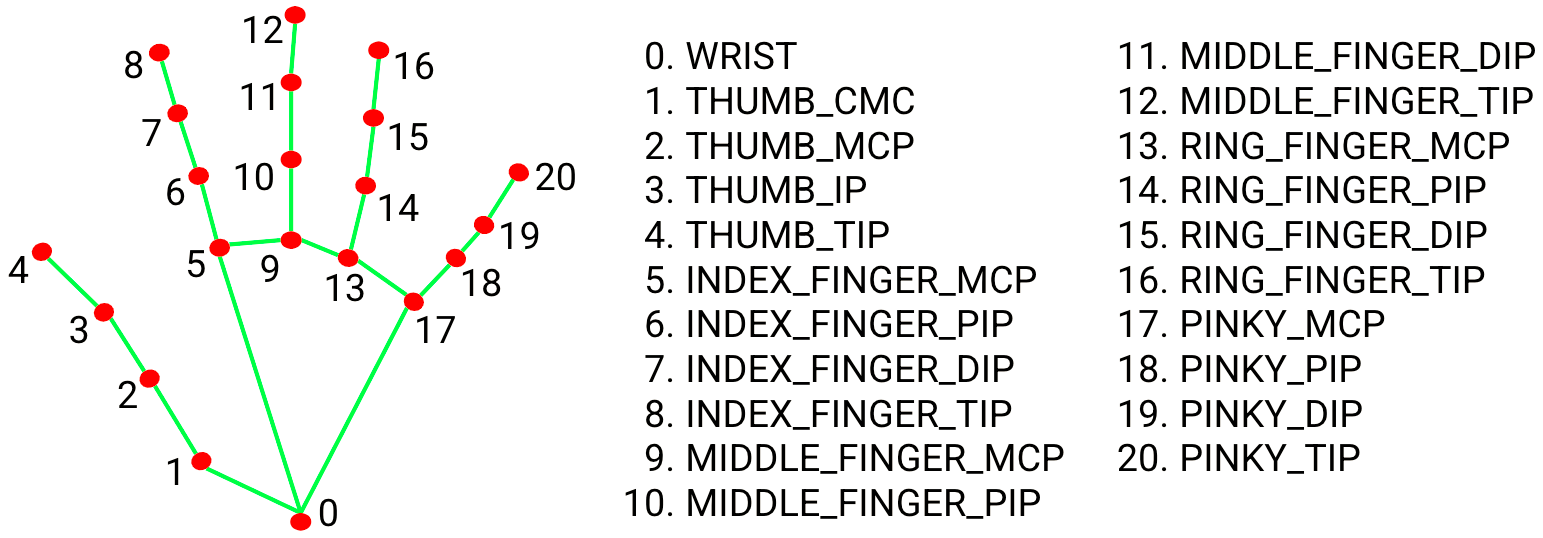

Le point zéro correspond donc au poignet. C'est en utilisant ce point comme référence que nous allons convertir les coordonnées absolues en coordonnées relatives.

Pour ce faire, nous allons diviser les valeurs xyz de chaque point par celles du point du poignet.

In [ ]:
dataset_rel = dataset2.copy()

for i in range(0,21):
    for j in range(0,len(dataset_rel)):
        dataset_rel[f"x{i}"][j] /= dataset_rel.iloc[j,3]
        dataset_rel[f"y{i}"][j] /= dataset_rel.iloc[j,4]
        dataset_rel[f"z{i}"][j] /= dataset_rel.iloc[j,5]

In [314]:
X = dataset_rel.iloc[:,3:]
y = dataset_rel.iloc[:, 2]

Réalisons le partage de nos données entre jeu d'entraînement et de test, d'abord avec un train_test_split() classique :

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(569, 63)
(64, 63)
(569,)
(64,)


On peut aussi utiliser StratifiedKFold qui peut parfois offrir de meilleurs résultats que train_test_split(). En effet, StratifiedKFold conserve les mêmes proportions pour chaque label dans le test comme dans le train.

In [105]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
print(skf)

for train_index, test_index in skf.split(X, y):
    X_train_2, X_test_2 = X.iloc[train_index], X.iloc[test_index]
    y_train_2, y_test_2 = y[train_index], y[test_index]    

print(X_train_2.shape)
print(X_test_2.shape)
print(y_train_2.shape)
print(y_test_2.shape)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
(317, 63)
(316, 63)
(317,)
(316,)


## Modèles

### Modèle Random Forest

A présent que nous disposons d'un système de détection des mains sur feed caméra ainsi que d'un dataset de landmarks de mains reliés à des labels de signes, nous allons pouvoir créer un modèle et l'entraîner avec ce dataset pour pouvoir prédire les signes sur feed.

Nous allons d'abord opter pour un classifieur de type Random Forest.

In [58]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

# Faisons une prédiction sur test : 
prediction = forest.predict(X_test)

# Vérifions la précision de notre prédiction :
precision = accuracy_score(y_test, prediction)
print("Précision du modèle :", precision)

Précision du modèle : 0.75


In [115]:
forest_2 = RandomForestClassifier()
forest_2.fit(X_train_2, y_train_2)

# Faisons une prédiction sur test : 
prediction = forest_2.predict(X_test_2)

# Vérifions la précision de notre prédiction :
precision = accuracy_score(y_test_2, prediction)
print("Précision du modèle :", precision)

Précision du modèle : 0.41455696202531644


Les modèles de forêts d'arbres décisionnels ont une bonne explicabilité mais présentent des performances moyennes. Un ANN peut être un meilleur choix.

Sur ce notebook, le StratifiedKFold ne semble pas avoir permis un gain de précision par rapport train_test_split().

### Réseau de neurones ANN :

Pour classifier les signes à partir des landmarks, nous avons entraîné une forêt d'arbres décisionnels mais nous pouvons également opter pour un réseau de neurones. Peut-être que cela fonctionnera mieux en conditions réelles lors de la prédiction sur feed webcam.

Notre modèle sera un simple ANN (réseau de neurones Dense).

Pour nos callbacks, nous allons simplement utiliser un checkpoint pour conserver les meilleurs poids possibles sur tous les epochs de l'entraînement (au regard de la val_accuracy).

In [361]:
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

checkpoint_filepath = './tmp/checkpoint' # Chemin vers le checkpoint de poids de modèle
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


NUM_CLASSES = 26 # (nos 26 classes de lettes)

#Model Initialization
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((63, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(120, activation='elu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(60, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

#Compiling the Model
model.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

#Model Fitting
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=6,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback] # On garde le meilleur checkpoint d'epoch
)


# On charge le meilleur checkpoint
model.load_weights(checkpoint_filepath)

Epoch 1/1000
95/95 [==============================] - 2s 5ms/step - loss: 3.3157 - accuracy: 0.0481 - val_loss: 3.2597 - val_accuracy: 0.0312
Epoch 2/1000
95/95 [==============================] - 0s 2ms/step - loss: 3.2136 - accuracy: 0.0680 - val_loss: 3.1327 - val_accuracy: 0.0938
Epoch 3/1000
95/95 [==============================] - 0s 2ms/step - loss: 3.0679 - accuracy: 0.1124 - val_loss: 3.0826 - val_accuracy: 0.0781
Epoch 4/1000
95/95 [==============================] - 0s 2ms/step - loss: 2.9952 - accuracy: 0.1494 - val_loss: 2.9484 - val_accuracy: 0.1406
Epoch 5/1000
95/95 [==============================] - 0s 2ms/step - loss: 2.8339 - accuracy: 0.1684 - val_loss: 2.7795 - val_accuracy: 0.2188
Epoch 6/1000
95/95 [==============================] - 0s 2ms/step - loss: 2.7080 - accuracy: 0.1951 - val_loss: 2.6681 - val_accuracy: 0.2500
Epoch 7/1000
95/95 [==============================] - 0s 2ms/step - loss: 2.5174 - accuracy: 0.2661 - val_loss: 2.5708 - val_accuracy: 0.3125
Epoch 

95/95 [==============================] - 0s 2ms/step - loss: 1.6493 - accuracy: 0.4854 - val_loss: 1.7234 - val_accuracy: 0.5000
Epoch 59/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.7016 - accuracy: 0.4683 - val_loss: 1.6622 - val_accuracy: 0.6250
Epoch 60/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.7421 - accuracy: 0.4738 - val_loss: 1.6719 - val_accuracy: 0.5938
Epoch 61/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.6873 - accuracy: 0.5021 - val_loss: 1.6158 - val_accuracy: 0.6250
Epoch 62/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.5661 - accuracy: 0.5258 - val_loss: 1.6227 - val_accuracy: 0.5625
Epoch 63/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.5878 - accuracy: 0.4986 - val_loss: 1.6677 - val_accuracy: 0.6094
Epoch 64/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.7637 - accuracy: 0.4739 - val_loss: 1.6113 - val_accuracy: 0.5781
Epoch 65/1000

95/95 [==============================] - 0s 2ms/step - loss: 1.4489 - accuracy: 0.5639 - val_loss: 1.5405 - val_accuracy: 0.6562
Epoch 116/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.3457 - accuracy: 0.6230 - val_loss: 1.5397 - val_accuracy: 0.6406
Epoch 117/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.5396 - accuracy: 0.5211 - val_loss: 1.5110 - val_accuracy: 0.5938
Epoch 118/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.3116 - accuracy: 0.6034 - val_loss: 1.4484 - val_accuracy: 0.6406
Epoch 119/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.3232 - accuracy: 0.5825 - val_loss: 1.5281 - val_accuracy: 0.6562
Epoch 120/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.4303 - accuracy: 0.5347 - val_loss: 1.5003 - val_accuracy: 0.6250
Epoch 121/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.3624 - accuracy: 0.5620 - val_loss: 1.5085 - val_accuracy: 0.6406
Epoch 1

Epoch 172/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1802 - accuracy: 0.5990 - val_loss: 1.4607 - val_accuracy: 0.6719
Epoch 173/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.2414 - accuracy: 0.5837 - val_loss: 1.5032 - val_accuracy: 0.6094
Epoch 174/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.2943 - accuracy: 0.5741 - val_loss: 1.4451 - val_accuracy: 0.6406
Epoch 175/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1796 - accuracy: 0.6235 - val_loss: 1.4047 - val_accuracy: 0.6094
Epoch 176/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1382 - accuracy: 0.6278 - val_loss: 1.4884 - val_accuracy: 0.6250
Epoch 177/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1658 - accuracy: 0.6215 - val_loss: 1.4110 - val_accuracy: 0.5938
Epoch 178/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.2014 - accuracy: 0.6200 - val_loss: 1.4808 - val_accuracy:

Epoch 229/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0542 - accuracy: 0.6472 - val_loss: 1.4887 - val_accuracy: 0.6406
Epoch 230/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0841 - accuracy: 0.6563 - val_loss: 1.4264 - val_accuracy: 0.6875
Epoch 231/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1419 - accuracy: 0.5907 - val_loss: 1.3984 - val_accuracy: 0.6875
Epoch 232/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1084 - accuracy: 0.6478 - val_loss: 1.5034 - val_accuracy: 0.6562
Epoch 233/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1125 - accuracy: 0.6457 - val_loss: 1.4020 - val_accuracy: 0.6875
Epoch 234/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0755 - accuracy: 0.6280 - val_loss: 1.3774 - val_accuracy: 0.6562
Epoch 235/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0215 - accuracy: 0.6440 - val_loss: 1.3452 - val_accuracy:

Epoch 286/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1104 - accuracy: 0.6171 - val_loss: 1.3930 - val_accuracy: 0.6094
Epoch 287/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.1266 - accuracy: 0.6535 - val_loss: 1.5048 - val_accuracy: 0.6094
Epoch 288/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9359 - accuracy: 0.6820 - val_loss: 1.4954 - val_accuracy: 0.6406
Epoch 289/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0808 - accuracy: 0.6401 - val_loss: 1.4782 - val_accuracy: 0.6250
Epoch 290/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8920 - accuracy: 0.6749 - val_loss: 1.4335 - val_accuracy: 0.6875
Epoch 291/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0513 - accuracy: 0.6370 - val_loss: 1.4094 - val_accuracy: 0.6875
Epoch 292/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0823 - accuracy: 0.6340 - val_loss: 1.4477 - val_accuracy:

Epoch 343/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9168 - accuracy: 0.6855 - val_loss: 1.3565 - val_accuracy: 0.7188
Epoch 344/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9324 - accuracy: 0.6657 - val_loss: 1.3535 - val_accuracy: 0.6875
Epoch 345/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8458 - accuracy: 0.7034 - val_loss: 1.3764 - val_accuracy: 0.7344
Epoch 346/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9923 - accuracy: 0.6618 - val_loss: 1.4030 - val_accuracy: 0.6719
Epoch 347/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0275 - accuracy: 0.6780 - val_loss: 1.3851 - val_accuracy: 0.7031
Epoch 348/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9917 - accuracy: 0.6955 - val_loss: 1.4388 - val_accuracy: 0.6719
Epoch 349/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8977 - accuracy: 0.6804 - val_loss: 1.5194 - val_accuracy:

Epoch 400/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7637 - accuracy: 0.7426 - val_loss: 1.4848 - val_accuracy: 0.6875
Epoch 401/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.8334 - accuracy: 0.7026 - val_loss: 1.3843 - val_accuracy: 0.7188
Epoch 402/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9056 - accuracy: 0.6756 - val_loss: 1.3946 - val_accuracy: 0.6719
Epoch 403/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8656 - accuracy: 0.7098 - val_loss: 1.3616 - val_accuracy: 0.6719
Epoch 404/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.8109 - accuracy: 0.6914 - val_loss: 1.4449 - val_accuracy: 0.7031
Epoch 405/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8685 - accuracy: 0.7178 - val_loss: 1.3969 - val_accuracy: 0.6562
Epoch 406/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9210 - accuracy: 0.6783 - val_loss: 1.3975 - val_accuracy:

Epoch 457/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.7879 - accuracy: 0.7243 - val_loss: 1.3321 - val_accuracy: 0.7500
Epoch 458/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9474 - accuracy: 0.7069 - val_loss: 1.3495 - val_accuracy: 0.6875
Epoch 459/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.9768 - accuracy: 0.6506 - val_loss: 1.3249 - val_accuracy: 0.6875
Epoch 460/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7038 - accuracy: 0.7315 - val_loss: 1.3403 - val_accuracy: 0.7500
Epoch 461/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.8593 - accuracy: 0.7120 - val_loss: 1.3911 - val_accuracy: 0.6406
Epoch 462/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9080 - accuracy: 0.6853 - val_loss: 1.4825 - val_accuracy: 0.6250
Epoch 463/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.9428 - accuracy: 0.6609 - val_loss: 1.4163 - val_accuracy:

Epoch 514/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.7576 - accuracy: 0.7105 - val_loss: 1.4009 - val_accuracy: 0.6875
Epoch 515/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7506 - accuracy: 0.7169 - val_loss: 1.5030 - val_accuracy: 0.6875
Epoch 516/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.7544 - val_loss: 1.4046 - val_accuracy: 0.6875
Epoch 517/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7837 - accuracy: 0.7285 - val_loss: 1.3173 - val_accuracy: 0.7188
Epoch 518/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8818 - accuracy: 0.7200 - val_loss: 1.4520 - val_accuracy: 0.6562
Epoch 519/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.8050 - accuracy: 0.7139 - val_loss: 1.3218 - val_accuracy: 0.7188
Epoch 520/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7869 - accuracy: 0.7365 - val_loss: 1.4243 - val_accuracy:

Epoch 571/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8445 - accuracy: 0.7194 - val_loss: 1.4004 - val_accuracy: 0.6562
Epoch 572/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8908 - accuracy: 0.7263 - val_loss: 1.3245 - val_accuracy: 0.6875
Epoch 573/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9049 - accuracy: 0.7139 - val_loss: 1.3579 - val_accuracy: 0.7031
Epoch 574/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7657 - accuracy: 0.7227 - val_loss: 1.2521 - val_accuracy: 0.7500
Epoch 575/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8213 - accuracy: 0.7208 - val_loss: 1.3350 - val_accuracy: 0.7500
Epoch 576/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.7280 - accuracy: 0.7643 - val_loss: 1.3445 - val_accuracy: 0.7500
Epoch 577/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7346 - accuracy: 0.7149 - val_loss: 1.4127 - val_accuracy:

Epoch 628/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8342 - accuracy: 0.7020 - val_loss: 1.3472 - val_accuracy: 0.7031
Epoch 629/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8051 - accuracy: 0.7063 - val_loss: 1.3643 - val_accuracy: 0.7344
Epoch 630/1000
95/95 [==============================] - 0s 2ms/step - loss: 1.0204 - accuracy: 0.6927 - val_loss: 1.3204 - val_accuracy: 0.7344
Epoch 631/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7546 - accuracy: 0.7583 - val_loss: 1.5046 - val_accuracy: 0.6719
Epoch 632/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6971 - accuracy: 0.7718 - val_loss: 1.3942 - val_accuracy: 0.7031
Epoch 633/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8081 - accuracy: 0.7526 - val_loss: 1.3664 - val_accuracy: 0.6719
Epoch 634/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7315 - accuracy: 0.7412 - val_loss: 1.3449 - val_accuracy:

Epoch 685/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7967 - accuracy: 0.7376 - val_loss: 1.3905 - val_accuracy: 0.6875
Epoch 686/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.8413 - accuracy: 0.6961 - val_loss: 1.3837 - val_accuracy: 0.7031
Epoch 687/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8540 - accuracy: 0.7241 - val_loss: 1.3575 - val_accuracy: 0.7188
Epoch 688/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6618 - accuracy: 0.7618 - val_loss: 1.3721 - val_accuracy: 0.7344
Epoch 689/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.9111 - accuracy: 0.7065 - val_loss: 1.3642 - val_accuracy: 0.7188
Epoch 690/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8430 - accuracy: 0.7478 - val_loss: 1.4525 - val_accuracy: 0.6719
Epoch 691/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8289 - accuracy: 0.7252 - val_loss: 1.3777 - val_accuracy:

Epoch 742/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7518 - accuracy: 0.7618 - val_loss: 1.3441 - val_accuracy: 0.7188
Epoch 743/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7283 - accuracy: 0.7335 - val_loss: 1.3441 - val_accuracy: 0.7344
Epoch 744/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.7680 - val_loss: 1.4003 - val_accuracy: 0.6875
Epoch 745/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7615 - accuracy: 0.7085 - val_loss: 1.4809 - val_accuracy: 0.6406
Epoch 746/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.7644 - val_loss: 1.4122 - val_accuracy: 0.6250
Epoch 747/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7602 - accuracy: 0.7449 - val_loss: 1.4045 - val_accuracy: 0.7031
Epoch 748/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7151 - accuracy: 0.7766 - val_loss: 1.3177 - val_accuracy:

Epoch 799/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.7965 - val_loss: 1.4114 - val_accuracy: 0.7031
Epoch 800/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.7734 - val_loss: 1.4350 - val_accuracy: 0.6875
Epoch 801/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.7527 - val_loss: 1.3602 - val_accuracy: 0.7188
Epoch 802/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.7489 - val_loss: 1.3546 - val_accuracy: 0.7188
Epoch 803/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7064 - accuracy: 0.7528 - val_loss: 1.3555 - val_accuracy: 0.7031
Epoch 804/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7282 - accuracy: 0.7710 - val_loss: 1.4746 - val_accuracy: 0.7031
Epoch 805/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.7354 - val_loss: 1.3933 - val_accuracy:

Epoch 856/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6717 - accuracy: 0.7757 - val_loss: 1.3723 - val_accuracy: 0.7031
Epoch 857/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.5970 - accuracy: 0.7736 - val_loss: 1.4074 - val_accuracy: 0.6562
Epoch 858/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.7811 - val_loss: 1.4766 - val_accuracy: 0.6719
Epoch 859/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6732 - accuracy: 0.7982 - val_loss: 1.4461 - val_accuracy: 0.6875
Epoch 860/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6728 - accuracy: 0.7551 - val_loss: 1.3791 - val_accuracy: 0.7344
Epoch 861/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7792 - accuracy: 0.7408 - val_loss: 1.4089 - val_accuracy: 0.7344
Epoch 862/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.7531 - val_loss: 1.4456 - val_accuracy:

Epoch 913/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6526 - accuracy: 0.7690 - val_loss: 1.4109 - val_accuracy: 0.7031
Epoch 914/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.7875 - val_loss: 1.3171 - val_accuracy: 0.7188
Epoch 915/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6634 - accuracy: 0.7618 - val_loss: 1.2147 - val_accuracy: 0.7188
Epoch 916/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.5999 - accuracy: 0.7788 - val_loss: 1.3408 - val_accuracy: 0.6875
Epoch 917/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7140 - accuracy: 0.7393 - val_loss: 1.3403 - val_accuracy: 0.7188
Epoch 918/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.8093 - accuracy: 0.7369 - val_loss: 1.3102 - val_accuracy: 0.7031
Epoch 919/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6210 - accuracy: 0.7971 - val_loss: 1.3218 - val_accuracy:

Epoch 970/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7490 - accuracy: 0.7363 - val_loss: 1.3945 - val_accuracy: 0.7031
Epoch 971/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.7469 - val_loss: 1.3742 - val_accuracy: 0.7188
Epoch 972/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.7718 - accuracy: 0.7477 - val_loss: 1.4125 - val_accuracy: 0.7344
Epoch 973/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.5642 - accuracy: 0.7792 - val_loss: 1.4749 - val_accuracy: 0.6875
Epoch 974/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6385 - accuracy: 0.7604 - val_loss: 1.5316 - val_accuracy: 0.7344
Epoch 975/1000
95/95 [==============================] - 0s 2ms/step - loss: 0.6249 - accuracy: 0.7788 - val_loss: 1.4653 - val_accuracy: 0.7344
Epoch 976/1000
95/95 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.7493 - val_loss: 1.3634 - val_accuracy:

Lors de tous les tests d'entraînement d'ANN, on peut sauvegarder un modèle qui nous plaît bien et le récupérer ainsi :
model.save('modele/ANN_signes')
model_backup = tf.keras.models.load_model('modele/ANN_signes')

On réalise la prédiction sur test :

In [127]:
prediction = model.predict(X_test)

Dans la mesure où notre ANN délivre des densités de probabilité par classe, si l'on souhaite pouvoir connaître son accuracy, il va falloir retourner sur un format de prédiction correspondant à des int de 0 à 25.

Voyons voir nos prédictions en récupérant l'argument maximal des densités de probabilités sorties par le softmax de la couche d'output.

In [131]:
prediction = [pred.argmax() for pred in prediction]
prediction

[20,
 16,
 7,
 19,
 3,
 16,
 12,
 0,
 13,
 5,
 19,
 1,
 5,
 2,
 6,
 10,
 2,
 4,
 3,
 7,
 0,
 6,
 10,
 0,
 14,
 18,
 25,
 5,
 12,
 17,
 20,
 7]

Vérifions la précision de notre prédiction :

In [135]:
precision = accuracy_score(y_test, prediction)
print("Précision du modèle :", precision*100, "%")

Précision du modèle : 81.25 %


Grâce au checkpoint, on termine avec une assez bonne précision malgré le dataset réduit et l'architecture encore loin d'être optimale.

## Programme final

Créons une fonction qui récupère et renvoie sous forme de liste les landmarks mediapipe en détectant la main sur une image passée en argument. Nous l'utiliserons pour nourir la prédiction sur flux vidéo.

In [137]:
def get_landmarks_feed(image, holistic):
    resultat = []

    detection = holistic.process(image)

    if detection.right_hand_landmarks == None:
        return None

    # On ajoute au resultat les coordonnées des keypoints de la main détectée (main droite prioritaire)
    else :
        for landmark in detection.right_hand_landmarks.landmark:
            resultat.append(landmark.x)
            resultat.append(landmark.y)
            resultat.append(landmark.z)

    return resultat

Créons une liste pour associer les int de 0 à 25 sortis par le modèles aux lettres de A à Z pour un affichage plus confortable :

In [156]:
alphabet = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

In [6]:
### Bloc de code pour permettre à la cellule de fonctionner en stand-alone
import tensorflow as tf # création et entraînement de modèles de deep learning keras
import mediapipe as mp
import cv2
import numpy as np
model = tf.keras.models.load_model('modele/ANN_signes')
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

def get_landmarks_feed(image, holistic):
    resultat = []

    detection = holistic.process(image)

    if detection.right_hand_landmarks == None:
        return None

    # On ajoute au resultat les coordonnées des keypoints de la main détectée (main droite prioritaire)
    else :
        for landmark in detection.right_hand_landmarks.landmark:
            resultat.append(landmark.x)
            resultat.append(landmark.y)
            resultat.append(landmark.z)

    return resultat

alphabet = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

### 

cap = cv2.VideoCapture(0)


key = 0

# On charge le modèle de détection en dehors de la boucle cv2 pour de meilleures performances sur feed :
try :
    # Paramétrage de mediapipe holistic :
    with mp_holistic.Holistic(min_detection_confidence = 0.6,
                      min_tracking_confidence=0.9) as holistic:

        while cap.isOpened() and key!=27: # Boucle de capture cv2
            ret, frame = cap.read()

            # Recoloration du feed en RGB pour la détection :
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            results = holistic.process(image) # Réalisation de la détection

            landmarks = get_landmarks_feed(image, holistic) # Obtention des keypoints pour la main détectée

            if landmarks != None:
                #coord = coord_relative(landmarks)
                coord = np.array(landmarks)
                print(coord)

                # Réalisation de la prédiction :
                prediction = model.predict(np.array(landmarks).reshape(1, -1))
                prediction = prediction[0].argmax()

                cv2.putText(frame, str(alphabet[prediction]), (10, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255))

            # Dessin des landmarks de chaque main
            mp_drawing.draw_landmarks(frame,
                              results.right_hand_landmarks,
                             mp_holistic.HAND_CONNECTIONS)


            cv2.imshow("Classification du langage des signes", frame)

            key = cv2.waitKey(10)
            
except Exception  as e: # Si cv2 crashe, on évite de casser le kernel python :
    print("Erreur :", e)
    cap.release()
    cv2.destroyAllWindows()

cap.release()
cv2.destroyAllWindows()

[ 2.26764947e-01  5.85884571e-01  2.38022731e-05  3.17308068e-01
  5.03616214e-01  7.94619042e-03  3.83074582e-01  4.10363942e-01
 -1.16336150e-02  4.45123255e-01  3.46391261e-01 -4.13849726e-02
  5.01977205e-01  3.08797956e-01 -7.19337240e-02  3.02134752e-01
  3.30810606e-01  3.81693132e-02  3.27187300e-01  2.63685137e-01
  3.81693011e-03  3.24385941e-01  3.39213938e-01  3.66524240e-04
  3.12284589e-01  3.67464662e-01  9.78338346e-03  2.55569905e-01
  3.36412698e-01  1.12517448e-02  2.84648657e-01  2.66666085e-01
 -6.22826740e-02  2.86451757e-01  3.63872826e-01 -8.12458098e-02
  2.70754755e-01  3.75770420e-01 -6.45120591e-02  2.10449725e-01
  3.49503577e-01 -1.87779423e-02  2.37000316e-01  2.93794721e-01
 -7.11611584e-02  2.47942343e-01  3.85916233e-01 -7.21387118e-02
  2.33225584e-01  3.94724667e-01 -5.64249642e-02  1.62628442e-01
  3.70244652e-01 -4.89906035e-02  1.91410154e-01  3.18122715e-01
 -6.60475791e-02  2.08140522e-01  3.85469317e-01 -5.96045814e-02
  1.92341805e-01  4.04914

[ 3.46069455e-01  5.78754544e-01  1.39366430e-05  4.27585959e-01
  4.99968141e-01  4.42312891e-03  4.83844876e-01  4.03360546e-01
 -1.43116675e-02  5.40472150e-01  3.46080422e-01 -3.89780030e-02
  5.94033718e-01  3.27377975e-01 -5.59543483e-02  4.07682955e-01
  3.05969417e-01  2.78029777e-02  4.47454393e-01  2.61048436e-01
 -5.98328887e-03  4.39622968e-01  3.47507924e-01  8.23082402e-03
  4.15048093e-01  3.69034737e-01  3.22546102e-02  3.59951377e-01
  3.13285500e-01  5.37599728e-04  4.09556478e-01  2.64211357e-01
 -7.56579861e-02  4.07441288e-01  3.76673371e-01 -7.30532557e-02
  3.77371073e-01  3.77032369e-01 -4.09256592e-02  3.16214204e-01
  3.28940570e-01 -3.50844860e-02  3.67888421e-01  2.87193388e-01
 -9.75211710e-02  3.74535024e-01  3.97953182e-01 -7.82720521e-02
  3.45805109e-01  4.03971255e-01 -4.80826236e-02  2.69976944e-01
  3.54046375e-01 -7.03098848e-02  3.22003365e-01  3.17779690e-01
 -9.93763804e-02  3.36766958e-01  3.98127139e-01 -8.63714069e-02
  3.08125317e-01  4.15235

[ 2.20564589e-01  5.84730148e-01  5.94384292e-05  2.98627615e-01
  5.06984532e-01 -3.56530286e-02  3.59904796e-01  4.10122395e-01
 -7.04101771e-02  4.23097581e-01  3.45872819e-01 -1.01790763e-01
  4.84480977e-01  3.21199596e-01 -1.28322214e-01  2.94711888e-01
  3.41418415e-01  8.55591428e-03  2.91212142e-01  2.67970741e-01
 -5.74370213e-02  2.91223198e-01  3.50273848e-01 -6.40071705e-02
  2.95308709e-01  3.69242579e-01 -4.22058143e-02  2.42679924e-01
  3.53596598e-01 -2.71510216e-04  2.44885549e-01  2.75962234e-01
 -1.05913125e-01  2.51090497e-01  3.81881952e-01 -1.17442571e-01
  2.55951643e-01  3.82445753e-01 -8.45827907e-02  1.96743011e-01
  3.73538136e-01 -1.91760920e-02  1.97690740e-01  3.08169633e-01
 -1.04783610e-01  2.14775264e-01  4.08707082e-01 -1.08067095e-01
  2.18425632e-01  4.09152418e-01 -8.16746131e-02  1.52298525e-01
  3.97889495e-01 -4.32305448e-02  1.58801943e-01  3.42895478e-01
 -7.57210776e-02  1.79594725e-01  4.11524564e-01 -7.24003240e-02
  1.78212345e-01  4.20228

[ 2.66399503e-01  6.48462653e-01 -1.44388323e-04  3.45420927e-01
  5.88447869e-01 -3.48115526e-02  3.96492541e-01  4.84323770e-01
 -5.14872037e-02  3.83269489e-01  3.86409461e-01 -7.27844313e-02
  3.34461153e-01  3.66479695e-01 -8.97370800e-02  3.39686006e-01
  3.51080805e-01  3.87835763e-02  3.34927708e-01  2.39455894e-01
  3.82376797e-02  3.27664763e-01  1.71465382e-01  2.70819087e-02
  3.18344593e-01  1.08415693e-01  1.32387104e-02  2.95113295e-01
  3.45090002e-01  3.30798551e-02  2.94781446e-01  2.23000273e-01
  4.49546985e-02  2.89752454e-01  1.42682582e-01  4.16755825e-02
  2.82340616e-01  7.91729689e-02  3.40658687e-02  2.55090296e-01
  3.55541825e-01  1.66215822e-02  2.56649405e-01  2.39205614e-01
  1.45950792e-02  2.58734554e-01  1.63507774e-01  9.96298715e-03
  2.55618006e-01  1.06251091e-01  3.08856787e-03  2.13346064e-01
  3.82823884e-01 -1.04518142e-02  2.17589766e-01  2.86943078e-01
 -1.25019765e-02  2.21595123e-01  2.25679278e-01 -1.61241498e-02
  2.20715776e-01  1.71232

## Perspectives

Notre application de classification de signes sur flux vidéo fonctionne clairement mieux que de l'aléatoire, on peut juger qu'elle offre des résultats très corrects en conditions réelles au vu de notre dataset réduit.

Si l'on était en entreprise et en assimilant notre travail à un POC (Proof Of Concept), on aurait démontré la faisabilité du projet et on pourrait travailler à l'amélioration de notre solution.

Comme perspectives, on pourrait imaginer créer un algorithme de création de nouvelles données directement sous forme de jeu de keypoints mediapipe et cela pour tous les signes ambigüs.

L'idée serait d'afficher sur flux vidéo le signe prédit par l'algorithme comme sur la solution actuelle. Ensuite, en mettant délibérément la main dans une position gênante qui trompe le modèle existant, on provoquerait une mauvaise prédiction. On appuierait ensuite sur un bouton pour enregistrer tous les keypoints de la main ainsi que le vrai label que le modèle aurait dû prédire sur ce cas limite.

Ainsi, on pourrait enrichir notre dataset et ré-entraîner notre modèle dessus pour avoir sans cesse de meilleurs résultats.

L'avantage de travailler avec des keypoints est qu'une fois la main bien détectée par mediapipe, seule la position des doigts compte au niveau de la data*. Contrairement à un problème de classification sur image où des inconnues comme l'éclairage, le teint de peau, le contraste, etc. peuvent influencer, un opérateur seul pourrait probablement simuler des milliers de variations dans la position de la main pour chaque signe et la données serait potentiellement généralisable à n'importe qui.

(*) : Bien sûr, sur la détection de la main en elle-même, le programme reste tributaire de l'image et il faut donc un bon éclairage, une webcam pas trop mauvaise, etc.